In [1]:
import sqlite3
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()
blue, green, red = sns.color_palette()[:3]

%matplotlib inline
%run Utils.ipynb

In [2]:
# Connect to the database
DB_PATH = '../resources/capstone_db.sqlite'
db = sqlite3.connect(DB_PATH)

# Get a cursor
cursor = db.cursor()

# Data Cleaning

In this notebook, we will clean the data keeping only the TCEs for which we have high confidence they are confirmed exoplanets and confirmed false positives. 

The main focus of this notbook is the analysis of the variables explaining the classification target variable:

* the Exoplanet Archive disposition VS the disposition using Kepler data classification variables 
* the confidence score (`koi_score`)
* the disposition comment (`koi_comment`)
* the false positive flags (`koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, `koi_fpflag_ec`) 

But, we will also :

* explore the quarters variable indicating the periods during which the stars have been monitored
* explore the transit signal-to-noise ratio and maximum multiple event statistic features because they are statistics related directly to the TCEs reliability
* handle the missing values

Note that the feature selection has already been done in the `2_1_Data_Preparation.ipynb` notebook

# 1. The variables explaining the classification target variable

In [3]:
# Load the classification target variables and the variables justifiying them
query = '''
SELECT 
    kepoi_name,
    koi_disposition,
    koi_pdisposition,
    koi_score,
    koi_comment,
    koi_fpflag_nt, 
    koi_fpflag_ss, 
    koi_fpflag_co, 
    koi_fpflag_ec
FROM
    kois_activity_table;
'''
df = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df.shape)
df.head()

KOIs Activity Table Shape: (7732, 9)


,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_comment,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
0,K00752.01,CONFIRMED,CANDIDATE,1.000,NO_COMMENT,0,0,0,0
1,K00752.02,CONFIRMED,CANDIDATE,0.969,NO_COMMENT,0,0,0,0
2,K00753.01,CANDIDATE,CANDIDATE,0.000,DEEP_V_SHAPED,0,0,0,0
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,MOD_ODDEVEN_DV---MOD_ODDEVEN_ALT---DEEP_V_SHAPED,0,1,0,0
4,K00755.01,CONFIRMED,CANDIDATE,1.000,NO_COMMENT,0,0,0,0


## 1.1 The Exoplanet Archive disposition VS the disposition using Kepler data

Except the confirmed exoplanet class, all other classes come from the disposition using Kepler data variable.  
Let's check if this is really the case and drop the potential inconsistencies:

In [4]:
# Get the counts of observation for each Disposition Using Kepler Data grouped by Exoplanet Archive Disposition
df.groupby('koi_disposition')['koi_pdisposition'].value_counts()

koi_disposition  koi_pdisposition
CANDIDATE        CANDIDATE           1804
CONFIRMED        CANDIDATE           2284
                 FALSE POSITIVE         6
FALSE POSITIVE   FALSE POSITIVE      3637
                 CANDIDATE              1
Name: koi_pdisposition, dtype: int64

In [5]:
# Drop the inconsistencies:
# -------------------------

# There are 6 confirmed exoplanets classified as false positives according to the Disposition using Kepler data
confirmed_inconsistencies = (df['koi_disposition'] == 'CONFIRMED') & (df['koi_pdisposition'] == 'FALSE POSITIVE')

# There is 1 false positive classified as candidate according to the Disposition using Kepler data
false_positive_inconsistencies = (df['koi_disposition'] == 'FALSE POSITIVE') & (df['koi_pdisposition'] == 'CANDIDATE')

# Drop the observations misclassified by the vetting algorithms (according to the Disposition from Exoplanet Archive)
kepoi_indices = df[confirmed_inconsistencies | false_positive_inconsistencies].index
kepoi_names   = list(df[confirmed_inconsistencies | false_positive_inconsistencies].kepoi_name.values)

df.drop(index=kepoi_indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'DISPOSITION_MISMATCH')

print('DataFrame Shape:', db_get_number_tces(cursor, excluded=False))
print('TCEs dropped:', len(kepoi_names))

DataFrame Shape: (7725,)
TCEs dropped: 7


## 1.2 The confidence score

The score is the confidence in the Disposition Using Kepler Data defined as:

>A value between 0 and 1 that indicates the confidence in the KOI disposition. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition. The value is calculated from a Monte Carlo technique such that the score's value is equivalent to the fraction of iterations where the Robovetter yields a disposition of CANDIDATE.

We want to train models with TCEs classified with high score of confidence. The analysis of the score distribution per disposition will help us to select these observations. Because this variable is strongly skewed,  plotting cumulative histrograms for the candidates and exoplanets and an inverse cumulative histrogram for the false positives, with a logarithmic scale, will provide better insight. 

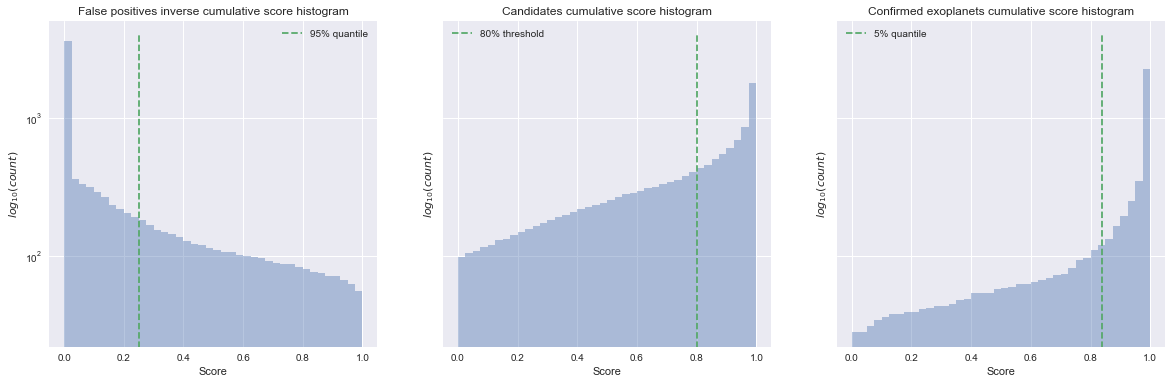

In [6]:
# Get the confirmed exoplanets 5% quantile score
confirmed_quantile_5 = df.loc[(df.koi_disposition == 'CONFIRMED'), 'koi_score'].quantile(0.05)

# Get the false positives 95% quantile score
false_positive_quantile_95 = df.loc[(df.koi_disposition == 'FALSE POSITIVE'), 'koi_score'].quantile(0.95)

# Candidates threshold
score_threshold = 0.8


fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

# False positives cumulative score histogram
sns.distplot(df.koi_score[df.koi_disposition == 'FALSE POSITIVE'], bins=40, kde=False, hist_kws={'cumulative': -1, 'log': True}, ax=ax[0])
ax[0].plot([false_positive_quantile_95, false_positive_quantile_95], [0, 4000], color=green, linestyle='dashed', label='95% quantile')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('$log_{10}(count)$')
ax[0].set_title('False positives inverse cumulative score histogram')
ax[0].legend()

# Candidates cumulative score histogram
sns.distplot(df.koi_score[df.koi_disposition == 'CANDIDATE'], bins=40, kde=False, hist_kws={'cumulative': 1, 'log': True}, ax=ax[1])
ax[1].plot([score_threshold, score_threshold], [0, 4000], color=green, linestyle='dashed', label='80% threshold')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('$log_{10}(count)$')
ax[1].set_title('Candidates cumulative score histogram')
ax[1].legend()

# Confirmed exoplanets cumulative score histogram
sns.distplot(df.koi_score[df.koi_disposition == 'CONFIRMED'], bins=40, kde=False, hist_kws={'cumulative': 1, 'log': True}, ax=ax[2])
ax[2].plot([confirmed_quantile_5, confirmed_quantile_5], [0, 4000], color=green, linestyle='dashed', label='5% quantile')
ax[2].set_xlabel('Score')
ax[2].set_ylabel('$log_{10}(count)$')
ax[2].set_title('Confirmed exoplanets cumulative score histogram')
ax[2].legend()

plt.show()

Most false positives have confidence scores near 0 and exoplanets near 1 but there are TCEs with low confidence scores to drop. The candidates have more spreaded scores but overall, they are concentrated with a score between 0.8 and 1, indicated by the "quadratic" trend.

We make the decisions to drop :

* the false positive TCEs with a score greater than the 95% quantile
* the confirmed exoplanet TCEs with score lower than the 5% quantile
* the candidate TCEs with a score below 0.8

In [7]:
# Drop the confirmed exoplanets with a score lower than the 5% quantile score
filter = (df.koi_disposition == 'CONFIRMED') & (df.koi_score <= confirmed_quantile_5)
idx = df.loc[filter].index
kepoi_names = list(df[filter].kepoi_name.values)
df.drop(axis=0, index=idx, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'SCORE')

print('Confirmed exoplanet 5% quantile: {:.3f}'.format(confirmed_quantile_5))
print('Number of confirmed exoplanets dropped: ', idx.shape[0])

Confirmed exoplanet 5% quantile: 0.839
Number of confirmed exoplanets dropped:  115


In [8]:
# Drop the false positives with a score greater than the 95% quantile score
filter = (df.koi_disposition == 'FALSE POSITIVE') & (df.koi_score > false_positive_quantile_95)
idx = df.loc[filter].index
kepoi_names = list(df[filter].kepoi_name.values)
df.drop(axis=0, index=idx, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'SCORE')

print('False positives 95% quantile: {:.3f}'.format(false_positive_quantile_95))
print('Number of false positives dropped: ', idx.shape[0])

False positives 95% quantile: 0.252
Number of false positives dropped:  182


In [9]:
# Drop the candidates with a score below 80%
filter = (df.koi_disposition == 'CANDIDATE') & (df.koi_score <= score_threshold)
idx = df.loc[filter].index
kepoi_names = list(df[filter].kepoi_name.values)
df.drop(axis=0, index=idx, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'SCORE')

print('Number of candidates dropped: ', idx.shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of candidates dropped:  410
DataFrame Shape:  (7018,)


## 1.3 The comments

The comment variable is the description of the reason why an object's disposition has been given as false positive. It may also contain a list of the minor tags as set by the Robovetter. These tags are describe here: https://exoplanetarchive.ipac.caltech.edu/docs/koi_comment_flags.html

In [10]:
# Get a sample of comments
df.koi_comment.head(10)

0                                            NO_COMMENT
1                                            NO_COMMENT
3      MOD_ODDEVEN_DV---MOD_ODDEVEN_ALT---DEEP_V_SHAPED
4                                            NO_COMMENT
5                                            NO_COMMENT
6                                            NO_COMMENT
7                                            NO_COMMENT
8     MOD_SEC_DV---MOD_SEC_ALT---HAS_SEC_TCE---CENT_...
9                                            NO_COMMENT
11    MOD_SEC_DV---PLANET_OCCULT_DV---MOD_SEC_ALT---...
Name: koi_comment, dtype: object

The tags are separated by three dashes ---.  
We will extract each tags and create a stacked dataframe with them:

In [11]:
# Extract each tag in a column called comment_tag (multi-index dataframe source index + match) 
df_comment_tags = df.koi_comment.str.extractall(r"(?P<comment_tag>[^---]+)")

# Reset index as the df dataframe and drop the match columns
df_comment_tags.reset_index(inplace=True, level=1)
df_comment_tags.drop(axis=1, columns=['match'], inplace=True)

# Merge with the df dataframe to recover the identification and target variables
df_comment_tags = pd.merge(df_comment_tags, df.loc[:, ['kepoi_name', 'koi_disposition']], left_index=True, right_index=True)
df_comment_tags = df_comment_tags[['kepoi_name', 'koi_disposition', 'comment_tag']]
df_comment_tags.head(15)

,kepoi_name,koi_disposition,comment_tag
0,K00752.01,CONFIRMED,NO_COMMENT
1,K00752.02,CONFIRMED,NO_COMMENT
3,K00754.01,FALSE POSITIVE,MOD_ODDEVEN_DV
3,K00754.01,FALSE POSITIVE,MOD_ODDEVEN_ALT
3,K00754.01,FALSE POSITIVE,DEEP_V_SHAPED
4,K00755.01,CONFIRMED,NO_COMMENT
5,K00756.01,CONFIRMED,NO_COMMENT
6,K00756.02,CONFIRMED,NO_COMMENT
7,K00756.03,CONFIRMED,NO_COMMENT
8,K00114.01,FALSE POSITIVE,MOD_SEC_DV


We want to drop the observations having rare tags. The tags distribution per disposition will allow to do identify the tags with sample size statistically not significant:

In [12]:
# Tags attributed to observations grouped by disposition
tags_per_disposition = df_comment_tags.groupby('koi_disposition')['comment_tag'].value_counts()

### 1.3.1 Tags attributed to the confirmed exoplanet TCEs

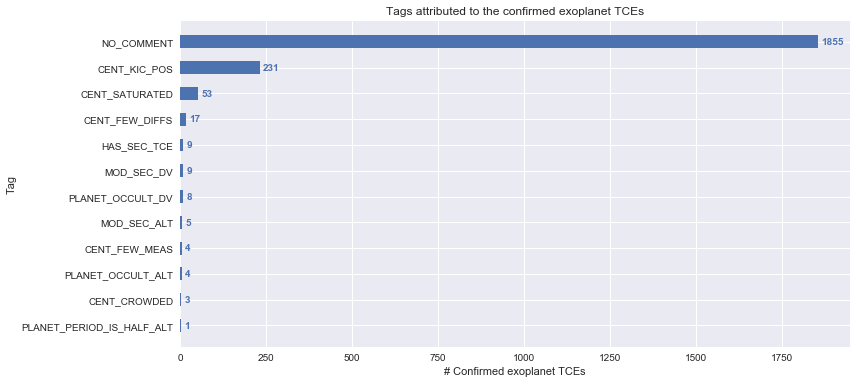

In [13]:
# Horizontal bar plot of the tags attributed to the confirmed exoplanet TCEs
eda_barh(tags_per_disposition['CONFIRMED'],
         xlabel='# Confirmed exoplanet TCEs',
         ylabel='Tag',
         title='Tags attributed to the confirmed exoplanet TCEs'
        )

We will keep only the exoplanets having the NO_COMMENT and the CENT_KIC_POS tags, all others having a sample size statistically not significant.  
The CENT_SATURATED tag is also dropped because the documentation states that this tag is a warning that the TCE can not be reliably evaluated. 

In [14]:
# Tags to drop
tags_to_drop = tags_per_disposition['CONFIRMED'][tags_per_disposition['CONFIRMED'] <= 53].index

# Exoplanet TCEs having these tags
filter = df_comment_tags.koi_disposition == 'CONFIRMED'
has_tag = df_comment_tags.loc[filter, 'comment_tag'].isin(tags_to_drop)
indices = has_tag[has_tag].index
kepoi_names = list(df_comment_tags.loc[filter, 'kepoi_name'].loc[has_tag].drop_duplicates().values)

# Drop these TCEs
df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'COMMENT')

print('Number of confirmed exoplanets dropped: ', indices.unique().shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of confirmed exoplanets dropped:  83
DataFrame Shape:  (6935,)


### 1.3.2 Tags attributed to the false positive TCEs

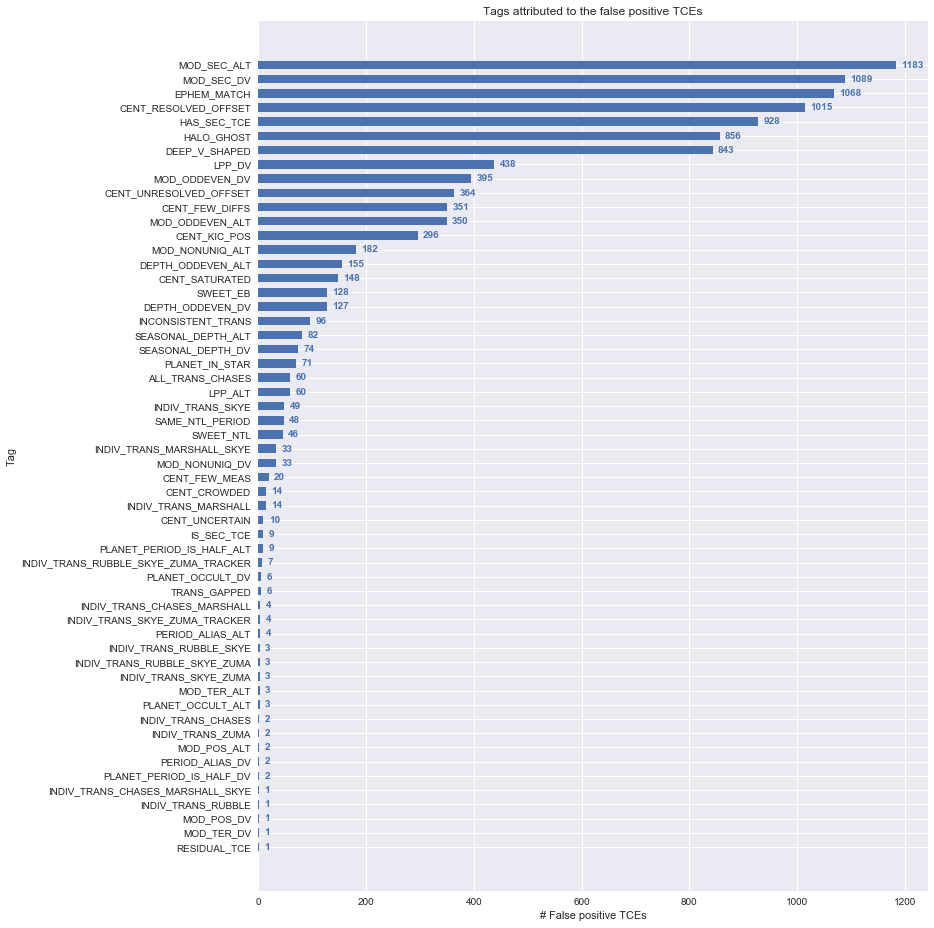

In [15]:
# Horizontal bar plot of tags attributed to the false positive TCEs
eda_barh(tags_per_disposition['FALSE POSITIVE'],
         xlabel='# False positive TCEs',
         ylabel='Tag',
         title='Tags attributed to the false positive TCEs',
         figsize=(12, 16),
         height=0.6
        )

The comment variable describe essentially the false positive class. We will drop the TCEs having tags with sample size statistically not significant :

In [16]:
# Get the sample size significant threshold (square root of the number of TCEs owning the most represented tag)
threshold = int(np.sqrt(tags_per_disposition['FALSE POSITIVE'][0]))
print('Sample size threshold of the false positive tags : ', threshold)

Sample size threshold of the false positive tags :  34


In [17]:
# Tags to drop
tags_to_drop = tags_per_disposition['FALSE POSITIVE'][tags_per_disposition['FALSE POSITIVE'] <= threshold].index

# False positive TCEs having these tags
filter = df_comment_tags.koi_disposition == 'FALSE POSITIVE'
has_tag = df_comment_tags.loc[filter, 'comment_tag'].isin(tags_to_drop)
indices = has_tag[has_tag].index
kepoi_names = list(df_comment_tags.loc[filter, 'kepoi_name'].loc[has_tag].drop_duplicates().values)

# Drop these TCEs
df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'COMMENT')

print('Number of false positives dropped: ', indices.unique().shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of false positives dropped:  189
DataFrame Shape:  (6746,)


### 1.3.3 Tags attributed to the candidate TCEs

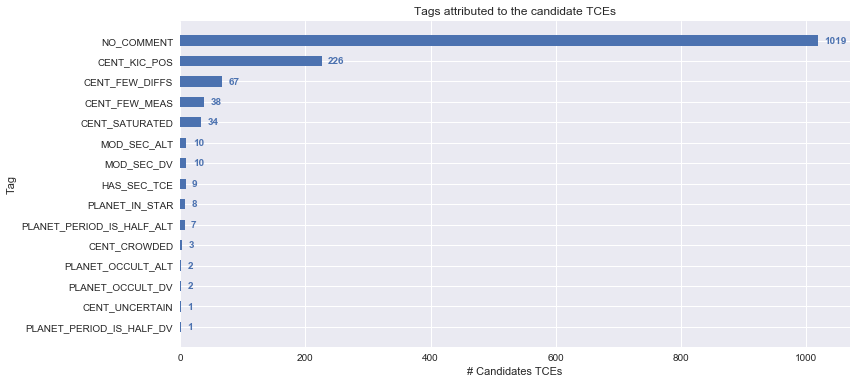

In [18]:
# Horizontal bar plot of tags attributed to the candidate TCEs
eda_barh(tags_per_disposition['CANDIDATE'],
         xlabel='# Candidates TCEs',
         ylabel='Tag',
         title='Tags attributed to the candidate TCEs',
        )

We will keep the candidate TCEs with the same tags than the confirmed exoplanets: NO_COMMENT and CENT_KIC_POS.  
Moreover, the documentation about the CENT_FEW_DIFFS, CENT_FEW_MEAS and CENT_SATURATED tags encourage to drop them :

In [19]:
# Tags to drop (all tags except the NO_COMMENT and CENT_KIC_POS tags)
tags_to_drop = tags_per_disposition['CANDIDATE'][~tags_per_disposition['CANDIDATE'].index.isin(['NO_COMMENT', 'CENT_KIC_POS'])].index

# Candidate TCEs having these tags
filter = df_comment_tags.koi_disposition == 'CANDIDATE'
has_tag = df_comment_tags.loc[filter, 'comment_tag'].isin(tags_to_drop)
indices = has_tag[has_tag].index
kepoi_names = list(df_comment_tags.loc[filter, 'kepoi_name'].loc[has_tag].drop_duplicates().values)

# Drop these TCEs
df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'COMMENT')

print('Number of candidates dropped: ', indices.unique().shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of candidates dropped:  154
DataFrame Shape:  (6592,)


## 1.4 The false positive flags

The disposition using Kepler data classification variable is set in function of the 4 following flags:

* Not Transit-Like Flag (`koi_fpflag_nt`)
* Stellar Eclipse Flag (`koi_fpflag_ss`)
* Centroid Offset Flag (`koi_fpflag_co`)
* Ephemeris Match Indicates Contamination Flag (`koi_fpflag_ec`)

In [20]:
# Fix the TCE with a Not Transit-Like flag value greater than 1 
df.koi_fpflag_nt = df.koi_fpflag_nt.map(lambda x: min(x, 1))

Exoplanets and candidates should have all four flags set to 0 and the false positives should have at least one of these flags set to 1. To lead this analysiss, we will engineer a false positive flag bitstring variable and count the number of TCEs per bitstring, grouped by disposition:

In [21]:
# Engineer a bitmask variable from the 4 flags
df['fpflag_bitstring'] = df.apply(lambda x: str(x.koi_fpflag_nt) + str(x.koi_fpflag_ss) + str(x.koi_fpflag_co) + str(x.koi_fpflag_ec), axis=1)
df.loc[:5, ['kepoi_name', 'koi_disposition', 'fpflag_bitstring']]

,kepoi_name,koi_disposition,fpflag_bitstring
0,K00752.01,CONFIRMED,0000
1,K00752.02,CONFIRMED,0000
3,K00754.01,FALSE POSITIVE,0100
4,K00755.01,CONFIRMED,0000
5,K00756.01,CONFIRMED,0000


In [22]:
# Distribution of bitstring per disposition
df.groupby('koi_disposition')['fpflag_bitstring'].value_counts()

koi_disposition  fpflag_bitstring
CANDIDATE        0000                1240
CONFIRMED        0000                2085
                 1000                   1
FALSE POSITIVE   0100                1080
                 0010                 415
                 0011                 361
                 1000                 327
                 0110                 325
                 0111                 312
                 1011                 143
                 1010                 101
                 0001                  94
                 1001                  60
                 0101                  48
Name: fpflag_bitstring, dtype: int64

The confirmed exoplanet with the not transit-like flag set to 1 should be dropped:

In [23]:
# Drop the explanet TCEs having flags set to 1
filter = (df.koi_disposition == 'CONFIRMED') & (df.fpflag_bitstring != '0000')
indices = df[filter].index
kepoi_names = list(df[filter].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'FALSE_POSITIVE_FLAGS')
print('Number of exoplanets dropped: ', indices.unique().shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False)) 

Number of exoplanets dropped:  1
DataFrame Shape:  (6591,)


Let's plot the distribution of the false positives per bitstring flags:

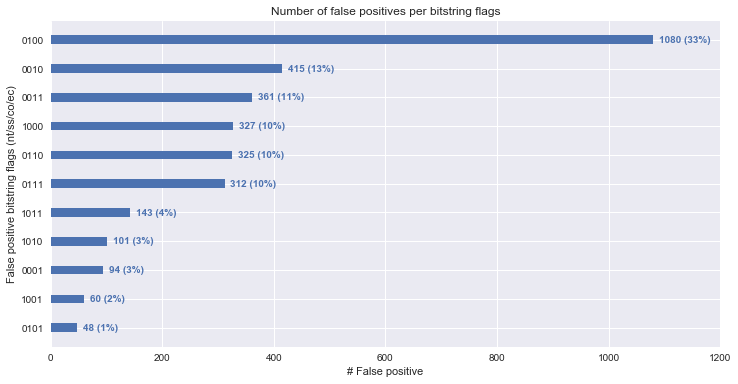

In [24]:
# counts and normalized counts of the false positive per categories
fp_counts = df.loc[df.koi_disposition == 'FALSE POSITIVE', 'fpflag_bitstring'].value_counts()
fp_counts_norm = df.loc[df.koi_disposition == 'FALSE POSITIVE', 'fpflag_bitstring'].value_counts(normalize=True)
x = pd.DataFrame({'counts': fp_counts, 'counts %': fp_counts_norm})

# plot the number of false positives per bitstring flags
plt.figure(figsize=(12, 6))
plt.barh(np.arange(x.shape[0]), x.iloc[:, 0], tick_label=x.index, height=0.3)
for i in range(x.shape[0]):
    text = str(x.iloc[i, 0]) + ' (' + str(int(np.round(x.iloc[i, 1] * 100))) + '%)'
    plt.text(x=x.iloc[i, 0] + 10, y=i, s=text, va='center', color=blue, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(0, 1200)
plt.title('Number of false positives per bitstring flags')
plt.xlabel('# False positive')
plt.ylabel('False positive bitstring flags (nt/ss/co/ec)')
plt.show()

The most represented category of false positives, 33% of them, are stellar eclipses, binary stars most likely. 
The three other pure categories, identified by only one flag are in order:
* the centroid offset flag (0010) representing 13% of the false positives
* the not transit-like flag (1000) representing 10% of the false positives
* the ephemeris match indicates contamination flag (0001) representing only 3% of the false positives

During the exploratory data analysis, it will be interesting to investigate about these subcategories and check if they obey to different patterns. Note that 41% of the false positives have been rejected for more than one reason.

In [25]:
# Get the data to load in the database
query = '''
SELECT 
    kepoi_name,
    koi_fpflag_nt, 
    koi_fpflag_ss, 
    koi_fpflag_co, 
    koi_fpflag_ec
FROM
    kois_activity_table;
'''
df_flags = pd.read_sql_query(query, db)
df_flags['fpflag_bitstring'] = df_flags.apply(lambda x: str(x.koi_fpflag_nt) + str(x.koi_fpflag_ss) + str(x.koi_fpflag_co) + str(x.koi_fpflag_ec), axis=1)

# Add a temporary table in the database for bulk load
df_flags.loc[:, ['kepoi_name', 'fpflag_bitstring']].to_sql(name='temp', con=db, if_exists='replace', index=False)

# Add the false positive flag bitstring column in the database
query = "ALTER TABLE tce_status ADD COLUMN fpflag_bitstring TEXT DEFAULT '';"
cursor.execute(query)

# Load the data in the new column
query = "UPDATE tce_status SET fpflag_bitstring = (SELECT fpflag_bitstring FROM temp WHERE tce_status.kepoi_name = temp.kepoi_name);"
cursor.execute(query)

In [26]:
# Commit the database updates done in this part
db.commit()

# 2. The quarters 

The monitoring of the stars is splitted in 17 measurement quarters. Between each quarter, the Kepler Telescope needed to be reoriented to receive energy from its solar panels. For some reasons, some stars has not been monitored during the 17 quarters, resulting of a lot of missing data in their light curves from which the transit models are derived. The nomenclature says that the Kepler pipeline handles these missing data with some interpolation. 

To build our models, we will get rid of the observations with missing measurement quarters or more precisely keep only the observations having contiguous quarters of measurement. Missing quarters at the beginning or end of the Kepler lifespan are less a concern.

The quarters variable (`quarters`) is a bit string with the first quarter indicated by the most significant bit, and so on...

In [27]:
# Load the number of transits and quarters variables
query = '''
SELECT 
    ts.kepoi_name,
    ts.kepid,
    kois.koi_disposition,
    sp.quarters
FROM
         tce_status AS ts 
    JOIN stellar_properties AS sp ON (ts.kepid = sp.kepid)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)

The source bitstring has more than 17 bits, we have to slice it to keep the first 17 significant bits. Moreover, we will engineer the following variables:

* A variable indicating the number of quarters (number of bits at 1)
* A variable indicating if there are missing quarters between measurement quarters (bit at 0 between bits at 1)

In [28]:
# Keep only the 17 first bits of the quarters bit string
df.quarters = df.quarters.str.slice(0, 17)

# Engineer a variable with the number of quarters in the quarters bit string
df['nb_quarters'] = df.quarters.map(lambda x: x.count('1'))

# Engineer an indicator variable indicating if there are missing quarters between measurements quarters 
# (missing quarters at the beginning or end are not a concern)
df['missing_quarter'] = df.quarters.map(lambda x: 1 if re.search('10+1', x) else 0)

print('Dataframe Shape:', df.shape)
df.head()

Dataframe Shape: (6591, 6)


,kepoi_name,kepid,koi_disposition,quarters,nb_quarters,missing_quarter
0,K00752.01,010797460,CONFIRMED,11111111111111111,17,0
1,K00752.02,010797460,CONFIRMED,11111111111111111,17,0
2,K00754.01,010848459,FALSE POSITIVE,11111110111011101,14,1
3,K00755.01,010854555,CONFIRMED,01111111111111111,16,0
4,K00756.01,010872983,CONFIRMED,01111101110111011,13,1


We decide to drop TCEs hosted by stars having missing quarters of measurement; these TCEs being less reliable by definition :

In [29]:
# Drop observations with missing measurement quarters
filter = (df.missing_quarter == 1)
indices = df[filter].index
kepoi_names = list(df[filter].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names[0:800], 'QUARTER')  # in two pass to avoid too many SQL variable error
db_exclude_tces(cursor, kepoi_names[800::], 'QUARTER')
print('Number of TCEs dropped: ', indices.unique().shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped:  1478
DataFrame Shape:  (5113,)


We can now investigate about the distribution of TCEs per number of contiguous quarters of measurement :

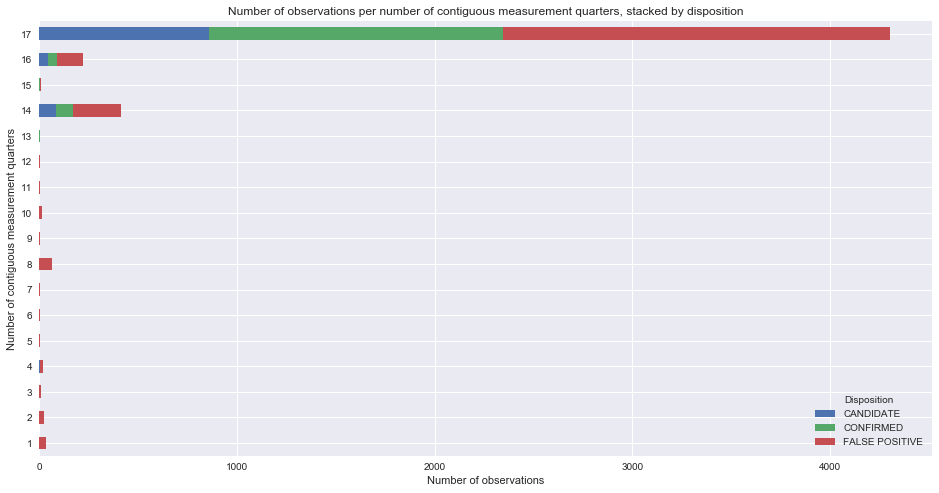

In [30]:
# Bar plot of the number of observations per number of contiguous measurement quarters, stacked by disposition 
df.groupby(by=['nb_quarters'])['koi_disposition'].value_counts() \
    .unstack() \
    .plot(kind='barh', stacked=True, figsize=(16, 8))

plt.xlabel('Number of observations')
plt.ylabel('Number of contiguous measurement quarters')
plt.title('Number of observations per number of contiguous measurement quarters, stacked by disposition')
plt.legend(title='Disposition')
plt.show()

Fortunately, most of the TCEs have been recorded around stars monitored during the 17 quarters. From the sample sizes, it would make sense to keep only the observations with at least 14 measurement quarters.

As we can see, the TCEs with few measurement quarters are mostly false positives. It can probably be explained by the fact that the probability to detect an exoplanet during a so short period of time is low. The full four and half year corresponds to only four Earth transits. A lot of chance would be required to detect a planet like Neptune with its period of revolution of 165 years.

The analysis of the transit period and duration will be done in a further EDA but we can expect to have TCEs with short transit periods.

In [31]:
# Drop TCEs hosted around stars with less than 14 measurement quarters
filter = (df.nb_quarters < 14)
indices = df[filter].index
kepoi_names = list(df[filter].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'QUARTER')
print('Number of TCEs dropped:', indices.shape[0])
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped: 172
DataFrame Shape:  (4941,)


In [32]:
# Commit the database updates done in this part
db.commit()

# 3. The maximum multiple event statistic and signal-to-noise ratio

In [33]:
# Load the statistic variables
query = '''
SELECT 
    ts.kepoi_name,
    kois.koi_disposition,
    stat.maxmes,
    stat.tsnr,
    ts.fpflag_bitstring
FROM
         tce_status AS ts 
    JOIN pipeline_statistics AS stat ON (ts.kepoi_name = stat.kepoi_name)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)
print('Dataframe Shape:', df.shape)
df.head()

Dataframe Shape: (4941, 5)


,kepoi_name,koi_disposition,maxmes,tsnr,fpflag_bitstring
0,K00752.01,CONFIRMED,28.470819,31.178432,0000
1,K00752.02,CONFIRMED,20.109507,20.690699,0000
2,K00755.01,CONFIRMED,33.191898,37.310295,0000
3,K00114.01,FALSE POSITIVE,46.153080,47.525490,0110
4,K00010.01,CONFIRMED,1725.582397,1687.046753,0000


## 3.1 The maxmimum multiple event statistic

According to the documentation, the maximum multiple event statistic can be exploited to help filter and sort samples of TCEs for the purposes of discerning the event quality, determining the likelihood of planet candidacy, or assessing the risks of observational follow-up. The MES estimates the signal to noise ratio of the putative transit-like sequence against the measurement noise. 

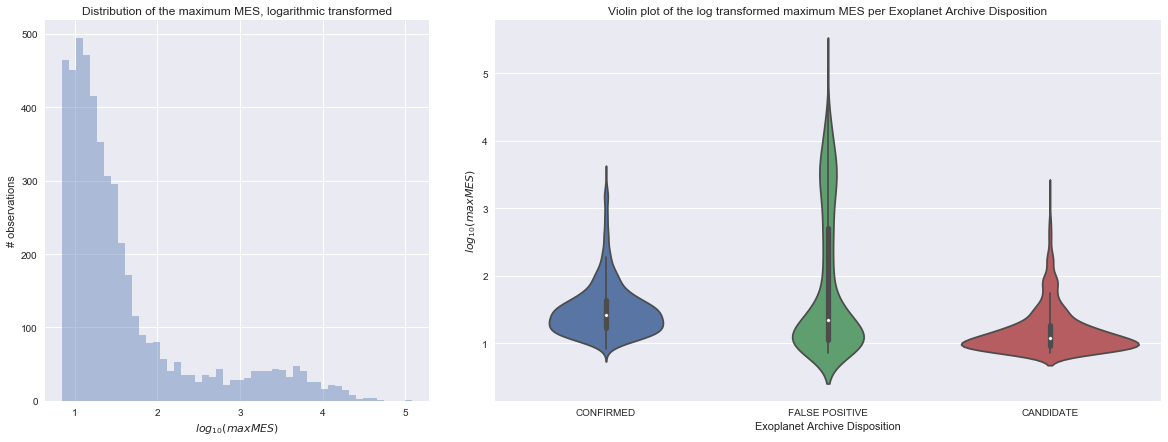

In [34]:
# Distribution of the log transformed max MES
plt.figure(figsize=(20, 7))
gridspec.GridSpec(1, 20)

plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=7)
sns.distplot(np.log10(df.maxmes), kde=False)
plt.xlabel('$log_{10}(maxMES)$')
plt.ylabel('# observations')
plt.title('Distribution of the maximum MES, logarithmic transformed')

# Violin plot of the max MES per Exoplanet Archive Disposition
plt.subplot2grid((1, 20), (0, 8), rowspan=1, colspan=13)
sns.violinplot(df.koi_disposition, np.log10(df.maxmes))
plt.xlabel('Exoplanet Archive Disposition')
plt.ylabel('$log_{10}(maxMES)$')
plt.title('Violin plot of the log transformed maximum MES per Exoplanet Archive Disposition')

plt.show()

Most of the TCEs tend to have low max MES. In astronomy, signals are often faint. The second "bumb" appears to be false positives, probably the stellar eclipses; their higher max MES, meaning they are easier to detect in the light curves. Let's confirm it:

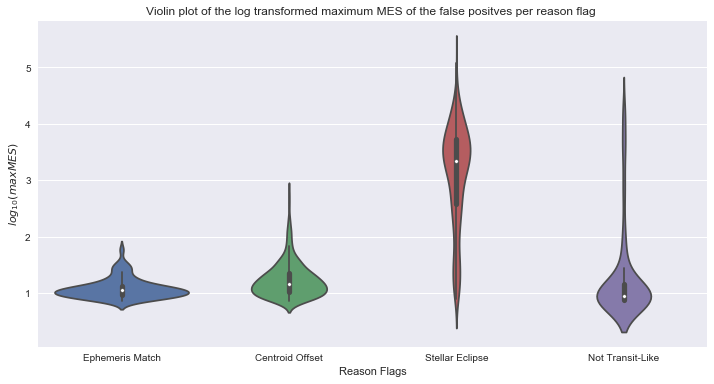

In [35]:
# Violin plot of the maximum MES of the false positives observations given their flags
filter = df.fpflag_bitstring.isin(['1000', '0100', '0010', '0001'])

plt.figure(figsize=(12, 6))
sns.violinplot(df.fpflag_bitstring[filter], np.log10(df.maxmes))
plt.xlabel('Reason Flags')
plt.gca().set_xticklabels(['Ephemeris Match', 'Centroid Offset', 'Stellar Eclipse', 'Not Transit-Like'])
plt.ylabel('$log_{10}(maxMES)$')
plt.title('Violin plot of the log transformed maximum MES of the false positves per reason flag ')
plt.show()

The stellar eclipse false positives are efffectively the second bumb in the histrogram.

Should we drop some outliers ?  

The TCE release notes (https://exoplanetarchive.ipac.caltech.edu/docs/tce_releasenotes_q1q12.pdf) states that all the activity table TCEs fullfill the maximum Multiple Event Statistic ≥ 7.1σ condition and that the maxMES and signal-to-noise ratio are correlated. 

Let's analyze the signal-to-noise ratio first.

## 3.2 The signal-to-noise ratio statistic

This variable is defined in the documentation as the transit depth normalized by the mean uncertainty in the flux during the transits. Let's look at its distribution but first dropping the TCE with signal-to-noise ratio lower than 1.

> There are 8 outliers resulting in negative log transformed SNR value

In [36]:
# Drop observations with missing transit signal-to-noise
filter = (df.tsnr < 1)
indices = df[filter].index
kepoi_names = list(df[filter].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'NAN_SNR')
print('Number of TCEs dropped: ', filter.sum())
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped:  8
DataFrame Shape:  (4933,)


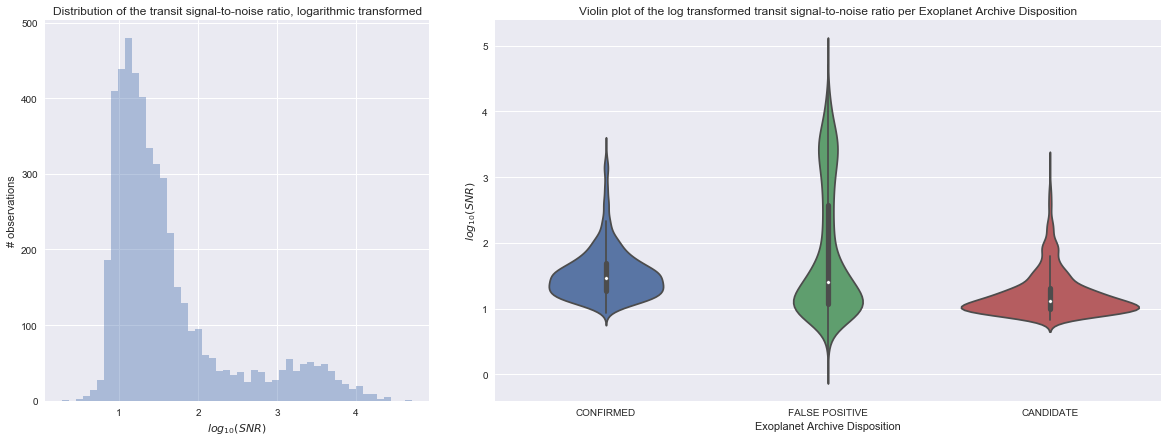

In [37]:
# Distribution of the log transformed signal-to-noise ratio
plt.figure(figsize=(20, 7))
gridspec.GridSpec(1, 20)
plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=7)
sns.distplot(np.log10(df.tsnr), kde=False)
plt.xlabel('$log_{10}(SNR)$')
plt.ylabel('# observations')
plt.title('Distribution of the transit signal-to-noise ratio, logarithmic transformed')

# Violin plot of the signal-to-noise ratio per Exoplanet Archive Disposition
plt.subplot2grid((1, 20), (0, 8), rowspan=1, colspan=13)
sns.violinplot(df.koi_disposition, np.log10(df.tsnr))
plt.xlabel('Exoplanet Archive Disposition')
plt.ylabel('$log_{10}(SNR)$')
plt.title('Violin plot of the log transformed transit signal-to-noise ratio per Exoplanet Archive Disposition')

plt.show()

The histrogram and violin plots are similar to the maxMES ones.
Let's look at their correlation:

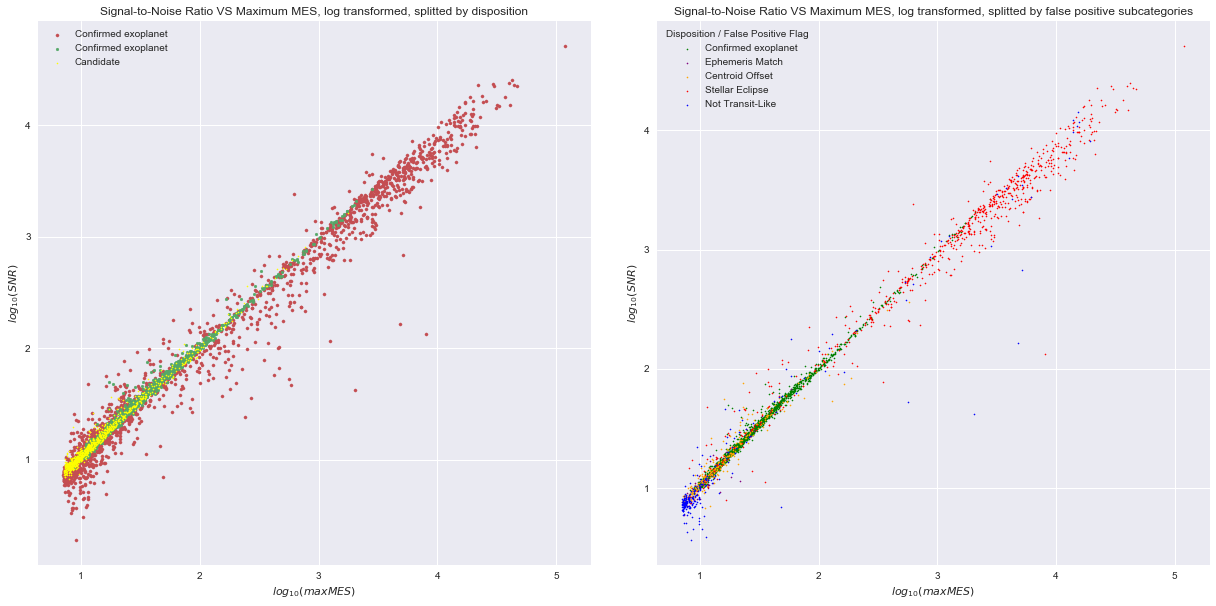

In [38]:
plt.figure(figsize=(21, 10))
gridspec.GridSpec(1, 21)

# SNR VS maxMES, log transformed, splitted by disposition
plt.subplot2grid((1, 21), (0, 0), rowspan=1, colspan=10)
plt.scatter(np.log10(df.loc[df.koi_disposition == 'FALSE POSITIVE', ['maxmes']]), 
            np.log10(df.loc[df.koi_disposition == 'FALSE POSITIVE', ['tsnr']]),
            s=10,
            c=red,
            label='Confirmed exoplanet'
           )
plt.scatter(np.log10(df.loc[df.koi_disposition == 'CONFIRMED', ['maxmes']]), 
            np.log10(df.loc[df.koi_disposition == 'CONFIRMED', ['tsnr']]),
            s=8,
            c=green,
            label='Confirmed exoplanet'
           )
plt.scatter(np.log10(df.loc[df.koi_disposition == 'CANDIDATE', ['maxmes']]), 
            np.log10(df.loc[df.koi_disposition == 'CANDIDATE', ['tsnr']]),
            s=1.5,
            c='yellow',
            label='Candidate'
           )
plt.xlabel('$log_{10}(maxMES)$')
plt.ylabel('$log_{10}(SNR)$')
plt.title('Signal-to-Noise Ratio VS Maximum MES, log transformed, splitted by disposition')
plt.legend()


# SNR VS maxMES, log transformed, splitted by disposition and false positive subcategories
plt.subplot2grid((1, 21), (0, 11), rowspan=1, colspan=10)
plt.scatter(np.log10(df.loc[df.koi_disposition == 'CONFIRMED', ['maxmes']]), 
            np.log10(df.loc[df.koi_disposition == 'CONFIRMED', ['tsnr']]),
            s=1.5,
            c='green',
            label='Confirmed exoplanet'
           )
plt.scatter(np.log10(df.loc[df.fpflag_bitstring == '0001', ['maxmes']]), 
            np.log10(df.loc[df.fpflag_bitstring == '0001', ['tsnr']]),
            s=1.5,
            c='purple',
            label='Ephemeris Match'
           )
plt.scatter(np.log10(df.loc[df.fpflag_bitstring == '0010', ['maxmes']]), 
            np.log10(df.loc[df.fpflag_bitstring == '0010', ['tsnr']]),
            s=1.5,
            c='orange',
            label='Centroid Offset'
           )
plt.scatter(np.log10(df.loc[df.fpflag_bitstring == '0100', ['maxmes']]), 
            np.log10(df.loc[df.fpflag_bitstring == '0100', ['tsnr']]),
            s=1.5,
            c='red',
            
            label='Stellar Eclipse'
           )
plt.scatter(np.log10(df.loc[df.fpflag_bitstring == '1000', ['maxmes']]), 
            np.log10(df.loc[df.fpflag_bitstring == '1000', ['tsnr']]),
            s=1.5,
            c='blue',
            label='Not Transit-Like'
           )
plt.xlabel('$log_{10}(maxMES)$')
plt.ylabel('$log_{10}(SNR)$')
plt.title('Signal-to-Noise Ratio VS Maximum MES, log transformed, splitted by false positive subcategories')
plt.legend(title='Disposition / False Positive Flag')

plt.show()

The log transformed two variables are clearly linearly correlated. However, the exoplanets appears to be less spreaded and better aligned. The candidates tends to follow the exoplanet trend even if most of them have low SNR and maxMES values, a region where it will be more challenging for our models to classify correctly the TCEs. The candidates with a maxMES between 1.5 and 2.5 are probably the most promising. 

The right scatter plot shows that the false positives subcategories form clusters. It will be probably easy for our models to classify correctly the stellar eclipses but more challenging to classify the other kinds of false positives. We have to be aware about the features that could help to identify them specifically.

We make the choice to don't use the statistics to train our models but in other project, we could build a linear model with only the confirmed exoplanets observations and engineer a variable representing the Euclidean distance of each data point to this model. Such a variable could say that observations far from the linear model have low probability to be an exoplanet, but not the reciproque condition.

In our case, we will train a linear model, compute the Euclidean distance of each data point to this model and drop the TCEs too far from the linear curve given the distance distribution : 

Number of TCEs dropped:  14
DataFrame Shape:  (4919,)


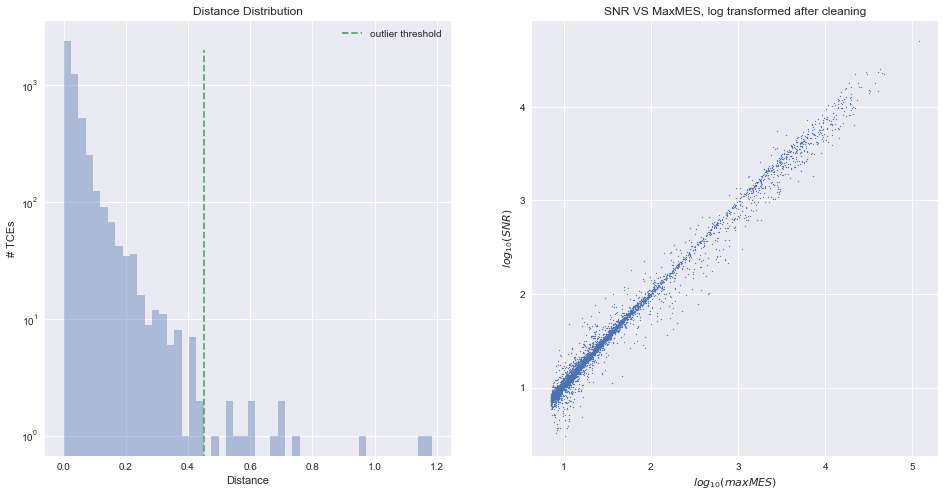

In [39]:
from sklearn.linear_model import HuberRegressor, LinearRegression

X = np.log10(df.maxmes).values
y = np.log10(df.tsnr).values

# Linear regression
lr = LinearRegression(fit_intercept=True)
lr.fit(X[:, np.newaxis], y)
a = lr.coef_[0]
b = lr.intercept_

# Compute the euclidean distance of each data points to the linear model
distance = np.abs(-a * X + y - b) / np.sqrt(np.square(a) + 1)
threshold = 0.45

# Distance distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(distance, kde=False, bins=50, hist_kws={'log': True}, ax=ax[0])
ax[0].plot([threshold, threshold], [0, 2000], linestyle='dashed', label='outlier threshold')
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('# TCEs')
ax[0].set_title('Distance Distribution')
ax[0].legend()

# Drop the outliers
outliers = (distance > threshold)
indices = df[outliers].index
kepoi_names = list(df[outliers].kepoi_name.values)

df.drop(axis=0, index=indices, inplace=True)
db_exclude_tces(cursor, kepoi_names, 'OUTLIER_SNR_MAXMES')
print('Number of TCEs dropped: ', outliers.sum())
print('DataFrame Shape: ', db_get_number_tces(cursor, excluded=False))

# SNR VS MaxMES after cleaning
ax[1].scatter(np.log10(df.maxmes), np.log10(df.tsnr), s=1)
ax[1].set_xlabel('$log_{10}(maxMES)$')
ax[1].set_ylabel('$log_{10}(SNR)$')
ax[1].set_title('SNR VS MaxMES, log transformed after cleaning')
plt.show()

# 4. Handling the missing values

In [40]:
# Load the statistic variables
query = '''
SELECT *
FROM
         tce_status AS ts
    JOIN transit_parameters AS tp ON (ts.kepoi_name = tp.kepoi_name)     
    JOIN pipeline_statistics AS stat ON (ts.kepoi_name = stat.kepoi_name)
    JOIN stellar_properties AS sp ON (ts.kepid = sp.kepid)
    JOIN magnitudes AS mag ON (ts.kepid = mag.kepid)
    JOIN location_motion AS lm ON (ts.kepid = lm.kepid)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)
print('Dataframe Shape:', df.shape)
df.head()

Dataframe Shape: (4919, 56)


,kepoi_name,kepid,excluded,exclusion_reason,fpflag_bitstring,kepoi_name,tperiod,tdepth,tdur,indur,...,gkcolor,kepid,skygroup,ra_obj,dec_obj,glon,glat,pmra,pmdec,pmtotal
0,K00752.01,010797460,0,,0000,K00752.01,9.488028,630.381630,3.418783,0.659365,...,2.243,010797460,18,291.93423,48.14165,80.102268,14.237782,0.0000,0.0000,0.0000
1,K00752.02,010797460,0,,0000,K00752.02,54.418374,893.123959,4.585753,0.257789,...,2.243,010797460,18,291.93423,48.14165,80.102268,14.237782,0.0000,0.0000,0.0000
2,K00755.01,010854555,0,,0000,K00755.01,2.525622,578.297482,1.624692,0.070214,...,2.064,010854555,24,288.75489,48.22620,79.293537,16.210389,0.0000,0.0000,0.0000
3,K00114.01,006721123,0,,0110,K00114.01,7.361795,230.745529,4.986959,2.493480,...,1.603,006721123,74,298.86434,42.15157,77.027023,7.127939,-0.0065,-0.0029,0.0071
4,K00010.01,006922244,0,,0000,K00010.01,3.522498,9139.882093,3.271061,0.526210,...,1.594,006922244,31,281.28812,42.45108,71.658900,19.012749,0.0000,0.0000,0.0000


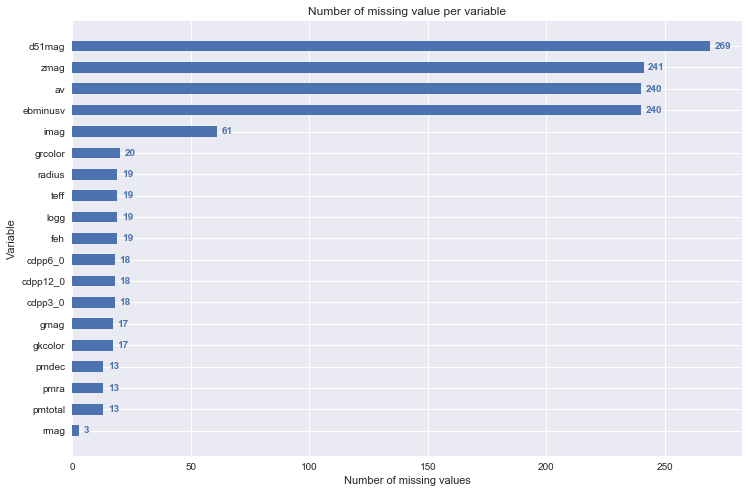

In [41]:
# Variables with missing values and counts
missing_values_count = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

# Horizontal bar plot
eda_barh(missing_values_count,
         xlabel='Number of missing values', 
         ylabel='Variable', 
         title='Number of missing value per variable', 
         figsize=(12, 8), 
         text_offset=2)

#### Drop the TCEs with missing stellar properties 

Stellar properties are among the main features, so we will drop the TCEs having `teff`, `logg`, `feh`, `radius` missing values :

In [42]:
# Drop the TCEs with missing stellar properties
filter = df.loc[:, ['teff', 'logg', 'feh', 'radius']].isnull().any(axis=1)
kepoi_names = list(df[filter].kepoi_name.values[:, 0])  # there are multiple kepoi_name columns in the dataframe

df.dropna(subset=['teff', 'logg', 'feh', 'radius'], inplace=True)
db_exclude_tces(cursor, kepoi_names, 'NAN_STELLAR')
print('Number of TCEs dropped: ', filter.sum())
print('\nDataFrame Shape:', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped:  19

DataFrame Shape: (4900,)


#### Drop observations with missing CDPP values

The Combined Differential Photometric Precision (CDPP) is the metric that defines the ease with which the weak  transit signatures can be detected.  
It is less risky to drop these TCEs :

In [43]:
# Drop TCEs with missing CDPP
filter = df.loc[:, ['cdpp3_0', 'cdpp6_0', 'cdpp12_0']].isnull().any(axis=1)
kepoi_names = list(df[filter].kepoi_name.values[:, 0])
                
df.dropna(subset=['cdpp3_0', 'cdpp6_0', 'cdpp12_0'], inplace=True)
db_exclude_tces(cursor, kepoi_names, 'NAN_CDPP')
print('Number of TCEs dropped: ', filter.sum())
print('\nDataFrame Shape:', db_get_number_tces(cursor, excluded=False))

Number of TCEs dropped:  18

DataFrame Shape: (4882,)


#### Replace proper motion missing values by 0

In [44]:
# Proper motions statistics
df.loc[:, ['pmtotal', 'pmra', 'pmdec']].describe().T

,count,mean,std,min,25%,50%,75%,max
pmtotal,4869.0,0.004853,0.020699,0.000,0.0,0.0,0.0055,0.6075
pmra,4869.0,-0.000429,0.013815,-0.536,0.0,0.0,0.0000,0.2780
pmdec,4869.0,-0.001027,0.016121,-0.464,0.0,0.0,0.0000,0.2860


Given the quantiles, we can safely replace the missing values by 0:

In [45]:
# Replace proper motion missing values by 0 (same as median)
for col in ['pmdec', 'pmra', 'pmtotal']:
    df.loc[df[col].isnull(), col] = 0.0
    
# Update the database (this is the same records having missing values in the three variables)
query = "UPDATE location_motion SET pmdec = 0.0, pmra = 0.0, pmtotal = 0.0 WHERE pmdec ISNULL;"
cursor.execute(query)
db.commit()

#### Handling extinction and reddening missing values

The `av` and `ebminusv` variables are respectively:

* A_V extinction of the star as reported in the Kepler Input Catalog
* B-V color eaxcess (reddening) of the star as reported in the Kepler Input Catalog

Extinction is the absorption and scattering of electromagnetic radiation by dust and gas between an emitting astronomical object and the observer. Interstellar reddening occurs because interstellar dust absorbs and scatters blue light waves more than red light waves, making stars appear redder than they are.

Given their definition, they are probably correlated :

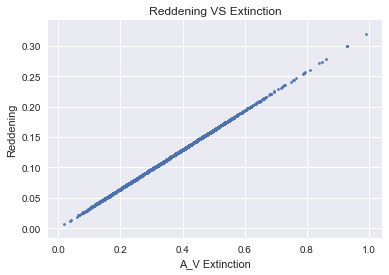

In [46]:
# Scatter plot of the reddening in function of the extinction
plt.scatter(df.av, df.ebminusv, s=6)
plt.xlabel('A_V Extinction')
plt.ylabel('Reddening')
plt.title('Reddening VS Extinction')
plt.show()

These variables are colinear, we will have to keep only one of them to train our models. There 240 TCEs with missing reddening, too much to simply drop them. 

Replacing the missing values by the mean value proved to be an unsuccessful approach. A better approach is to replace the missing values by the value of the star having the nearest temperature because light wavelength/color is related to the star temperature :

In [47]:
def index_of_stars_having_the_nearest_temperature(x, idx):
    return (np.abs(x - df[~df.index.isin(idx)]['teff'])).idxmin()

# Indices of observations with missing Reddening
idx_missing = df.ebminusv[df.ebminusv.isnull()].index

# Indices of observations having the nearest effective temperature from observations with missing reddening
idx_nearest = df.teff[idx_missing].map(lambda x: index_of_stars_having_the_nearest_temperature(x, idx_missing))

# Replace missing reddening values by the reddening values of the star having the nearest effective temperature
df.loc[df.ebminusv.isnull(), ['ebminusv']] = df.ebminusv[idx_nearest].values

In [48]:
# Indices of observations with missing Extinction
idx_missing = df.av[df.av.isnull()].index

# Indices of observations having the nearest effective temperature from observations with missing extinction
idx_nearest = df.teff[idx_missing].map(lambda x: index_of_stars_having_the_nearest_temperature(x, idx_missing))

# Replace missing extinction values by the reddening values of the star having the nearest effective temperature
df.loc[df.av.isnull(), ['av']] = df.av[idx_nearest].values

We have to update the database:

In [49]:
# Add a temporary table in the database for bulk update
query = "DROP TABLE IF EXISTS temp;"
cursor.execute(query)
df.loc[:, ['kepid', 'ebminusv', 'av']].iloc[:, -3:].to_sql(name='temp', con=db, if_exists='replace', index=False)

# Update the data
query = "UPDATE stellar_properties SET ebminusv = (SELECT ebminusv FROM temp WHERE stellar_properties.kepid = temp.kepid);"
cursor.execute(query)

query = "UPDATE stellar_properties SET av = (SELECT av FROM temp WHERE stellar_properties.kepid = temp.kepid);"
cursor.execute(query)
db.commit()

#### Handling magnitude missing values

As a compromise between precision and ease, we will replace the missing values of the band magnitude as follow:

1. For each band magnitude variables having missing data, compute the median of the delta between the band magnitude and the kepler magnitude
2. Replace the band magnitude missing data by adding the corresponding delta to the known kepler magnitude

In [50]:
# Handle missing values of the band magnitudes
for var in ['d51mag', 'imag', 'gmag', 'rmag', 'zmag']:
    # median of the delta between the band magnitude and the kepler magnitude
    delta_median = (df[var] - df.kepmag).median()

    # replace missing values by sum of the kepler magnitude and the median of the delta
    df.loc[df[var].isnull(), [var]] = df.kepmag[df[var].isnull()] + delta_median

The color variables:
* grcolor: SDSS (g-r) bands color magnitude
* gkcolor: SDSS g - 2MASS K, (g-K) color magnitude

are, as described, differences between band magnitudes (gmag - rmag) and (gmag - kmag) respectively.

We will replace the missing values by computing these differences.

In [51]:
# Handle gr color missing values
idx = df[df.grcolor.isnull()].index
df.loc[idx, ['grcolor']] = df.gmag[idx] - df.rmag[idx]

# Handle gk color missing values
idx = df[df.gkcolor.isnull()].index
df.loc[idx, ['gkcolor']] = df.gmag[idx] - df.kmag[idx]

We have to update the database:

In [52]:
# Add a temporary table in the database for bulk update
query = "DROP TABLE IF EXISTS temp;"
cursor.execute(query)
df.loc[:, ['kepid', 'd51mag', 'imag', 'gmag', 'rmag', 'zmag', 'grcolor', 'gkcolor']].iloc[:, -8:].to_sql(name='temp', con=db, if_exists='replace', index=False)

# Update the data
for col in ['d51mag', 'imag', 'gmag', 'rmag', 'zmag', 'grcolor', 'gkcolor']:
    query = "UPDATE magnitudes SET " + col + " = (SELECT " + col + " FROM temp WHERE magnitudes.kepid = temp.kepid);"
    cursor.execute(query)
    
db.commit()